<a href="https://colab.research.google.com/github/dileep9968/finetunning-T5-for-custom-summarization/blob/main/fine_tuned_phi_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load dataset

In [46]:
!pip install datasets
!pip install -U bitsandbytes
!pip install bitsandbytes --upgrade
!pip install accelerate --upgrade
!pip install peft --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.3/336.3 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.1.1
    Uninstalling accelerate-1.1.1:
      Successfully uninstalled accelerate-1.1.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: peft
    Found existing installation: peft 0.13.2
    Uninstalling peft-0.13.2:
      Successfully uninstalled peft-0.13.2


In [1]:
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict

In [2]:
df = pd.read_csv('https://github.com/laxmimerit/ALL-CSV-ML-Data-Files-Download/raw/master/amazon_product_details.csv',
                 usecols = ['category', 'about_product', 'product_name'])

In [3]:
df.head()

,product_name,category,about_product
0,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,High Compatibility : Compatible With iPhone 12...
1,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,"Compatible with all Type C enabled devices, be..."
2,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,【 Fast Charger& Data Sync】-With built-in safet...
3,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,The boAt Deuce USB 300 2 in 1 cable is compati...
4,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,[CHARGE & SYNC FUNCTION]- This cable comes wit...


In [4]:
df['category']=df['category'].apply(lambda x: x.split('|')[-1])
df.head()

,product_name,category,about_product
0,Wayona Nylon Braided USB to Lightning Fast Cha...,USBCables,High Compatibility : Compatible With iPhone 12...
1,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,USBCables,"Compatible with all Type C enabled devices, be..."
2,Sounce Fast Phone Charging Cable & Data Sync U...,USBCables,【 Fast Charger& Data Sync】-With built-in safet...
3,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,USBCables,The boAt Deuce USB 300 2 in 1 cable is compati...
4,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,USBCables,[CHARGE & SYNC FUNCTION]- This cable comes wit...


In [5]:
df['category'].value_counts()

,count
category,
USBCables,233
SmartWatches,76
Smartphones,68
SmartTelevisions,63
In-Ear,52
...,...
Split-SystemAirConditioners,1
SmallApplianceParts&Accessories,1
StovetopEspressoPots,1


In [6]:
products  =df[['category', 'product_name']]
description = df[['category', 'about_product']]
products = products.rename(columns={'product_name':'text'})
description = description.rename(columns={'about_product':'text'})

products['task_type']='Product Name'
description['task_type']='Product Description'

In [7]:
products.head()

,category,text,task_type
0,USBCables,Wayona Nylon Braided USB to Lightning Fast Cha...,Product Name
1,USBCables,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Product Name
2,USBCables,Sounce Fast Phone Charging Cable & Data Sync U...,Product Name
3,USBCables,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Product Name
4,USBCables,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Product Name


In [8]:
description.head()

,category,text,task_type
0,USBCables,High Compatibility : Compatible With iPhone 12...,Product Description
1,USBCables,"Compatible with all Type C enabled devices, be...",Product Description
2,USBCables,【 Fast Charger& Data Sync】-With built-in safet...,Product Description
3,USBCables,The boAt Deuce USB 300 2 in 1 cable is compati...,Product Description
4,USBCables,[CHARGE & SYNC FUNCTION]- This cable comes wit...,Product Description


In [9]:
df = pd.concat([products, description], ignore_index = True)
df

,category,text,task_type
0,USBCables,Wayona Nylon Braided USB to Lightning Fast Cha...,Product Name
1,USBCables,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Product Name
2,USBCables,Sounce Fast Phone Charging Cable & Data Sync U...,Product Name
3,USBCables,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Product Name
4,USBCables,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Product Name
...,...,...,...
2925,WaterPurifierAccessories,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,Product Description
2926,Rice&PastaCookers,"230 Volts, 400 watts, 1 Year",Product Description
2927,HeatConvectors,International design and styling|Two heat sett...,Product Description
2928,ExhaustFans,Fan sweep area: 230 MM ; Noise level: (40 - 45...,Product Description


In [10]:


dataset = Dataset.from_pandas(df)
dataset = dataset.shuffle(seed=0)
dataset = dataset.train_test_split(test_size=0.1)
dataset

DatasetDict({
    train: Dataset({
        features: ['category', 'text', 'task_type'],
        num_rows: 2637
    })
    test: Dataset({
        features: ['category', 'text', 'task_type'],
        num_rows: 293
    })
})

In [11]:
dataset['test'][0]

{'category': 'DryIrons',
 'text': '1.75kg heavy weight iron for better ironing;5 fabric settings|360 degree swivel cord for easy movement;Golden American heritage soleplate|1000watt-effective performance;Shock proof plastic handle and body|Easy grip fabric selector;Warranty: 2 years',
 'task_type': 'Product Description'}

## Hist Plot

In [12]:
products['text_tokens']=products['text'].apply(lambda x: len(x.split())*1.5)
description['text_tokens']=description['text'].apply(lambda x: len(x.split())*1.5)


In [13]:
products.head()

,category,text,task_type,text_tokens
0,USBCables,Wayona Nylon Braided USB to Lightning Fast Cha...,Product Name,48.0
1,USBCables,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Product Name,46.5
2,USBCables,Sounce Fast Phone Charging Cable & Data Sync U...,Product Name,40.5
3,USBCables,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Product Name,48.0
4,USBCables,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Product Name,30.0


<Axes: >

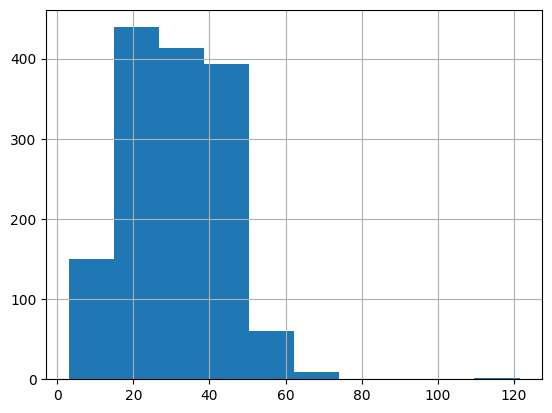

In [14]:
products['text_tokens'].hist()

<Axes: >

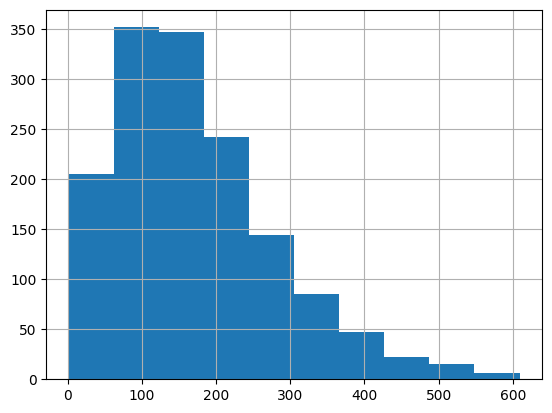

In [15]:
description['text_tokens'].hist()

## Formating

```
Given the product category, you need to generate a [Prodcut Name/ Product Description]

### Category: [USB Cable]

### [Product Name/ Product Description]: [Put product name or description]
```

In [16]:
def formatting_func(example):
  text = f"""
          Given the product category, you need to generate a '{example['task_type']}'
          ### Category: {example['category']}\n ### {example['task_type']}: {example['text']}
          """

  return text

In [17]:
print(formatting_func(dataset['train'][0]))


          Given the product category, you need to generate a 'Product Name' 
          ### Category: USBCables
 ### Product Name: Wayona Type C To Type C 65W/3.25A Nylon Braided Fast Charging Cable Compatible For Laptop, Macbook, Samsung Galaxy M33 M53 M51 S20 Ultra, A71, A53, A51, Ipad Pro 2018 (1M, Grey)
          


## Load Base Model and Tokenize

In [29]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = 'microsoft/phi-2'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [30]:
#get_ipython().kernel.do_shutdown(restart=True)


In [31]:
model = AutoModelForCausalLM.from_pretrained(base_model_id,
                                             trust_remote_code =True,
                                             torch_dtype = torch.float16,
                                             load_in_8bit = True)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [32]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_size = 'left',
    add_eos_token = True,
    add_bos_token = True,
    use_fast = False,

)
tokenizer.pad_token = tokenizer.eos_token

In [33]:
max_length = 400

def tokenize(prompt):
  result = tokenizer(
      formatting_func(prompt),
      truncation = True,
      max_length = max_length,
      padding = 'max_length'
  )
  result['labels'] = result['input_ids'].copy()
  return result

In [34]:

print(tokenize(dataset['train'][0]))

{'input_ids': [50256, 198, 50278, 15056, 262, 1720, 6536, 11, 345, 761, 284, 7716, 257, 705, 15667, 6530, 6, 220, 198, 50278, 21017, 21743, 25, 1294, 2749, 2977, 198, 44386, 8721, 6530, 25, 6378, 4450, 5994, 327, 1675, 5994, 327, 6135, 54, 14, 18, 13, 1495, 32, 399, 15158, 9718, 1384, 12549, 14797, 278, 20249, 3082, 16873, 1114, 406, 45007, 11, 4100, 2070, 11, 10397, 9252, 337, 2091, 337, 4310, 337, 4349, 311, 1238, 14563, 11, 317, 4869, 11, 317, 4310, 11, 317, 4349, 11, 314, 15636, 1041, 2864, 357, 16, 44, 11, 13980, 8, 198, 50278, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,

In [35]:
dataset = dataset.map(tokenize)

Map:   0%|          | 0/2637 [00:00<?, ? examples/s]

Map:   0%|          | 0/293 [00:00<?, ? examples/s]

In [36]:

eval_prompt = """
Givenn the product category, you need to generate a 'Product Description'.
### Category: BattryChargers
### Product Description
"""

In [39]:
# tokenize -> generate -> decode

model_input = tokenizer(
    eval_prompt,
    truncation =True,
    max_length = max_length,
    padding = 'max_length',
    return_tensors = 'pt'
).to(device)

In [40]:
model.eval()
with torch.no_grad():
  output  = model.generate(
      **model_input,
      max_new_tokens = 256,
      repetition_penalty = 1.15
  )
  result = tokenizer.decode(output[0], skip_special_tokens=True)
  print(result)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Givenn the product category, you need to generate a 'Product Description'.
### Category: BattryChargers
### Product Description                  

The BattryCharger is an innovative device that combines two essential features - charging and wireless connectivity. It's designed for users who are always on-the-go but also value convenience and efficiency in their devices' performance. 

Here are some facts about the BattryCharger:
1. The Charging Speed: The BattryCharger can charge your phone up to 50% faster than other chargers.
2. Wireless Connectivity: The BattryCharger allows you to connect wirelessly with any Bluetooth enabled device.
3. Compatibility: The BattryCharger works with all major smartphone brands including Apple, Samsung, Google Pixel, etc.
4. Durability: The BattryCharger is made of high-quality materials ensuring its durability even under harsh conditions.
5. Energy Efficiency: The BattryCharger uses less energy compared to traditional chargers, making it eco-friendly

## Lora Config

In [41]:
from peft import LoraConfig, get_peft_model

In [43]:

target_modules = ['Wqkv','fc1','fc2']


config = LoraConfig(
    r =32,
    lora_alpha = 64,
    target_modules= target_modules,
    bias='none',
    lora_dropout=0.05,
    task_type='CAUSAL_LM'
)

model = get_peft_model(model, config)


In [44]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PeftModelForCausalLM(
      (base_model): LoraModel(
        (model): PhiForCausalLM(
          (model): PhiModel(
            (embed_tokens): Embedding(51200, 2560)
            (embed_dropout): Dropout(p=0.0, inplace=False)
            (layers): ModuleList(
              (0-31): 32 x PhiDecoderLayer(
                (self_attn): PhiSdpaAttention(
                  (q_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
                  (k_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
                  (v_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
                  (dense): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
                  (rotary_emb): PhiRotaryEmbedding()
                )
                (mlp): PhiMLP(
                  (activation_fn): NewGELUActivation()
                  (fc1): lora.Linear8bitLt(
                    (base_layer)

In [56]:
def print_trainable_parameters(model):
  trainable_params = 0
  all_param = 0

  for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
      trainable_params += param.numel()
  print(
      f"trainable params: {trainable_params}\nall params: {all_param}\ntrainable%: {100 * trainable_params / all_param}"
  )


In [57]:
print_trainable_parameters(model)

trainable params: 26214400
all params: 2805898240
trainable%: 0.9342605382581515


In [58]:
from accelerate import Accelerator

accelerator = Accelerator(gradient_accumulation_steps=1)
model = accelerator.prepare(model)

In [59]:
# Trainer, Traing Arguments, DataCollator
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datetime import datetime

project = 'phi2-finetune'
run_name = 'train_dir'
output_dir = './'+ run_name

args = TrainingArguments(
    output_dir = output_dir,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=1,
    max_steps = 500,
    learning_rate = 2.5e-5,
    optim = 'paged_adamw_8bit',
    logging_steps = 25,
    logging_dir = './logs',
    save_strategy='steps',
    save_steps = 25,
    evaluation_strategy='steps',
    eval_steps = 25,
    do_eval = True
    )

trainer = Trainer(
    model = model,
    args = args,
    train_dataset = dataset['train'],
    eval_dataset = dataset['test'],
    data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
)

model.config.use_cache = False
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss
25,3.729100,3.475002
50,3.541200,3.270693
75,3.346000,3.050520
100,3.172200,2.899994
125,2.776200,2.816769
150,2.690200,2.760669
175,2.782000,2.736932
200,2.805200,2.717939
225,2.720700,2.708731
250,2.673900,2.691602


TrainOutput(global_step=500, training_loss=2.8261885681152346, metrics={'train_runtime': 1505.2459, 'train_samples_per_second': 0.664, 'train_steps_per_second': 0.332, 'total_flos': 6419582976000000.0, 'train_loss': 2.8261885681152346, 'epoch': 0.37907505686125853})

## Load PEFT Model

In [61]:
# load base model -> merge peft model

import torch
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    trust_remote_code =True,
    torch_dtype = torch.float16,
    load_in_8bit = True,
    device_map = 'auto'
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_size = 'left',
    add_eos_token = True,
    add_bos_token = True,
    use_fast = False,
    trust_remote_code = True,
    device_map = 'auto'
)

eval_tokenizer.pad_token = eval_tokenizer.eos_token



The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [62]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model,
                                     '/content/train_dir/checkpoint-500')

/usr/local/lib/python3.10/dist-packages/peft/peft_model.py:599: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.model.layers.0.mlp.fc1.lora_A.default.weight', 'base_model.model.model.layers.0.mlp.fc1.lora_B.default.weight', 'base_model.model.model.layers.0.mlp.fc2.lora_A.default.weight', 'base_model.model.model.layers.0.mlp.fc2.lora_B.default.weight', 'base_model.model.model.layers.1.mlp.fc1.lora_A.default.weight', 'base_model.model.model.layers.1.mlp.fc1.lora_B.default.weight', 'base_model.model.model.layers.1.mlp.fc2.lora_A.default.weight', 'base_model.model.model.layers.1.mlp.fc2.lora_B.default.weight', 'base_model.model.model.layers.2.mlp.fc1.lora_A.default.weight', 'base_model.model.model.layers.2.mlp.fc1.lora_B.default.weight', 'base_model.model.model.layers.2.mlp.fc2.lora_A.default.weight', 'base_model.model.model.layers.2.mlp.fc2.lora_B.default.weight', 'base_model.model.model.layers.3.mlp.fc1.lora_A.default.weight', 'base_model.model.mo

In [65]:
ft_model.eval()
with torch.no_grad():
  output  = ft_model.generate(
      **model_input,
      max_new_tokens = 400,
      repetition_penalty = 1.15
  )
  result = eval_tokenizer.decode(output, skip_special_tokens=True)
  print(result)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Givenn the product category, you need to generate a 'Product Description'.
### Category: BattryChargers
### Product Description                  

The BattryCharger is an innovative device that combines two essential features - charging and wireless connectivity. It's designed for users who are always on-the-go but also value convenience and efficiency in their devices' performance. 

Here are some facts about the BattryCharger:
1. The Charging Speed: The BattryCharger can charge your phone up to 50% faster than other chargers.
2. Wireless Connectivity: The BattryCharger allows you to connect wirelessly with any Bluetooth enabled device.
3. Compatibility: The BattryCharger works with all major smartphone brands including Apple, Samsung, Google Pixel, etc.
4. Durability: The BattryCharger is made of high-quality materials ensuring its durability even under harsh conditions.
5. Energy Efficiency: The BattryCharger uses less energy compared to traditional chargers, making it eco-friendly